# Capstone Project - Battle Of The London Boroughs
## Where do I move next?

In [1]:
# Third party library imports
import folium
import geocoder
import pandas as pd
import requests
import matplotlib.pyplot as plt

from dotenv import dotenv_values
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
%matplotlib inline

In [37]:
config = dotenv_values('.env')

four_id = config['CLIENT_ID']
four_sc = config['CLIENT_SECRET']

## Intorduction
This report is the final submission to the IBM Data Science Professional Certification Coursera course. Its aim is to demonstrate how today's data scientists can utilise the free APIs and open-source machine learning libraries to provide meaningful insights buisnes insights.

## The problem to solve
An estate agency company has approached me. They wish to provide their customers with peace of mind that the area they are moving to is precisely what they are looking for. Using the machine learning techniques I have learned throughout this course, I will analyse a number of London Boroughs to identify the similarities and differences between potential places to live. The agency will then be able to tell their customers if the area they are moving to is anything like where they are coming from or whether it is an entirely different vibe. 


## The Data
This project will utilise a number of data sources:
<ul>
    <li> The arcgis API for python </li>
    <li> The Foursquare API </li>
    <li> Postcodes.io API </li>
</ul>


### Geocoder Library and ArcGIS
The ArcGIS and Geocoder libraries can be used togeher to retrieve geographical data for specific addresses. <br>
Link: https://developers.arcgis.com

In [4]:
# National Physics Laboratory - Teddington, London
npl_geoData = geocoder.arcgis('TW11 0LW')
npl_geoData.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'TW11 0LW',
    'bbox': [-0.34182997606174104,
     51.42260001403074,
     -0.33982997606174103,
     51.42460001403074],
    'confidence': 9,
    'lat': 51.42360001403074,
    'lng': -0.34082997606174104,
    'ok': True,
    'quality': 'PostalExt',
    'raw': {'name': 'TW11 0LW',
     'extent': {'xmin': -0.34182997606174104,
      'ymin': 51.42260001403074,
      'xmax': -0.33982997606174103,
      'ymax': 51.42460001403074},
     'feature': {'geometry': {'x': -0.34082997606174104,
       'y': 51.42360001403074},
      'attributes': {'Score': 100, 'Addr_Type': 'PostalExt'}}},
    'score': 100,
    'status': 'OK'},
   'bbox': [-0.34182997606174104,
    51.42260001403074,
    -0.33982997606174103,
    51.42460001403074],
   'geometry': {'type': 'Point',
    'coordinates': [-0.34082997606174104, 51.42360001403074]}}]}

### Forsquare API
The Forsquare API can be utilised to return venues and locations within a given radious of a specific point. <br>
Link: https://foursquare.com

In [5]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    four_id, 
    four_sc, 
    20120609,
    npl_geoData.lat, 
    npl_geoData.lng,
    # Search radious 100m
    100, 
    # Top 100 results
    100)

results = requests.get(url).json()

In [6]:
# Here we see that there aren't many (1) locations of interest within 100m of the National Physics Laboratory 
results['response']

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
 'headerLocation': 'Teddington',
 'headerFullLocation': 'Teddington, London',
 'headerLocationGranularity': 'neighborhood',
 'totalResults': 0,
 'suggestedBounds': {'ne': {'lat': 51.42450001493074,
   'lng': -0.3393893385939807},
  'sw': {'lat': 51.422700013130736, 'lng': -0.3422706135295014}},
 'groups': [{'type': 'Recommended Places',
   'name': 'recommended',
   'items': []}]}

### Postcode.io API
The postcode API allows users to send request based on the latitude and longitude or postcode of a location and retrieve information for that area. <br>
Link: https://postcodes.io

In [7]:
url_codes = 'https://api.postcodes.io/postcodes?lon={}&lat={}'.format(
    npl_geoData.lng, 
    npl_geoData.lat
)

codes = requests.get(url_codes).json()
codes['result'][0]

{'postcode': 'TW11 0LW',
 'quality': 1,
 'eastings': 515458,
 'northings': 170734,
 'country': 'England',
 'nhs_ha': 'London',
 'longitude': -0.340797,
 'latitude': 51.423865,
 'european_electoral_region': 'London',
 'primary_care_trust': 'Richmond and Twickenham',
 'region': 'London',
 'lsoa': 'Richmond upon Thames 021C',
 'msoa': 'Richmond upon Thames 021',
 'incode': '0LW',
 'outcode': 'TW11',
 'parliamentary_constituency': 'Twickenham',
 'admin_district': 'Richmond upon Thames',
 'parish': 'Richmond upon Thames, unparished area',
 'admin_county': None,
 'admin_ward': 'Teddington',
 'ced': None,
 'ccg': 'NHS South West London',
 'nuts': 'Hounslow and Richmond upon Thames',
 'codes': {'admin_district': 'E09000027',
  'admin_county': 'E99999999',
  'admin_ward': 'E05000530',
  'parish': 'E43000217',
  'parliamentary_constituency': 'E14001005',
  'ccg': 'E38000245',
  'ccg_id': '36L',
  'ced': 'E99999999',
  'nuts': 'UKI75',
  'lsoa': 'E01003888',
  'msoa': 'E02000804',
  'lau2': 'E050

# Methodology

To demonstrate the principle of this analysis, I will be trying to find locations similar to Teddington, London. It is sae to assume that any client will have an idea of where they would like to live, so rather than searching all of London, a very computationally heavy process, I will select a few popular boroughs and run comparisons over them. This way, we would be able to suggest to a client where is best from a shotlist they provide. 

Our client currently lives in Teddington
<ul>
  <li> <strong> Teddington </strong> - TW11 0AZ </li>
</ul>
Our client wishes to stay in the south of London, so for comparison we will chose:
<ul>
  <li>Bromley - BR1 3NN </li>
  <li>Thornton Heath - CR7 7JG</li>
  <li>Croydon - CR0 2TA </li>
  <li>Surbiton - KT6 4PE</li>
  <li>Stoneleigh - KT19 0QZ</li>
  <li>Morden - SM4 5AZ</li>
  <li>Sutton - SM1 1DE</li>
  <li>Wallington - SM6 0DZ</li>
  <li>Tooting - SW17 0SU </li>
  <li>Norbury - SW16 4EJ </li>
  <li>Feltham - TW13 4BY </li>
  <li>Kingston - KT1 1SW </li>
</ul>

## Visulise these locations on a map

In [8]:
# We begin by initialising a dataframe of the desired boroughs
borough_df = pd.DataFrame([
  {'Town': 'Teddington'     , 'Postcode': 'TW11 0AZ'},
  {'Town': 'Kingston'       , 'Postcode': 'KT1 1TP'},
  {'Town': 'Surbiton'       , 'Postcode': 'KT6 4PE'},
  {'Town': 'Stoneleigh'     , 'Postcode': 'KT19 0QZ'},
  {'Town': 'Morden'         , 'Postcode': 'SM4 5AZ'},
  {'Town': 'Sutton'         , 'Postcode': 'SM1 1DE'},
  {'Town': 'Wallington'     , 'Postcode': 'SM6 0DZ'},
  {'Town': 'Thornton Heath' , 'Postcode': 'CR7 7JG'},
  {'Town': 'Bromley'        , 'Postcode': 'BR1 3NN'}, 
  {'Town': 'Croydon'        , 'Postcode': 'CR0 2TA'}, 
  {'Town': 'Tooting'        , 'Postcode': 'SW17 0SU'},
  {'Town': 'Norbury'        , 'Postcode': 'SW16 4EJ'},
  {'Town': 'Putney'         , 'Postcode': 'SW15 1RT'},
  {'Town': 'Feltham'        , 'Postcode': 'TW13 4BY'},
])

In [9]:
# Next, we feed each postcode into the ArcGIS geocoder library

for i, row in borough_df.iterrows():
    code = row.Postcode
    LL = geocoder.arcgis(f'{row.Postcode}, London').latlng
    borough_df.loc[i,'Latitude'] = LL[0]
    borough_df.loc[i,'Longitude'] = LL[1]

In [10]:
sw_London = folium.Map(location=[51.4, -0.20], zoom_start=11)

for i, row in borough_df.iterrows():
    if row.Town == 'Teddington':
        col = 'red'
    else:
        col = 'blue'
    label = folium.Popup(f'{row.Town} - {row.Postcode}')

    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=8,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.3,
        parse_html=False).add_to(sw_London) 
sw_London

We can begin with some more generalised analysis. So lets begin with the basic task of pulling the top 250 locations within 1.5km of each location. 

In [11]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    four_id, 
    four_sc, 
    20120609,
    # Centre search on North Your district 
    51.42425, 
    -0.33298,
    # Search radious 1.5km 
    1500, 
    # Top 100 results
    250)

results = requests.get(url).json()

In [13]:
print('Request response code: ', results['meta']['code'])
print('Returned ', results['response']['totalResults'], ' items')

Request response code:  200
Returned  70  items


In [14]:
# Data handling functions

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# convert response json into dataframe
teddington_places_df = pd.DataFrame(pd.json_normalize(results['response']['groups'][0]['items']))
# extract the important data items
teddington_places_df = teddington_places_df[['venue.name', 'venue.location.postalCode', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
teddington_places_df['venue.categories'] = teddington_places_df.apply(get_category_type, axis=1)

# rename columns
teddington_places_df = teddington_places_df.rename(
    columns={
        'venue.name': 'Name', 
        'venue.location.postalCode':'Postcode', 
        'venue.categories': 'Category', 
        'venue.location.lat':'Latitude', 
        'venue.location.lng': 'Longitude'
    }
)

teddington_places_df.head()

,Name,Postcode,Category,Latitude,Longitude
0,The Fallow Deer Café,TW11 8HG,Café,51.427435,-0.327876
1,Bushy Park,TW12 2EJ,Park,51.417232,-0.337275
2,Diners Delight,TW11 8PF,Café,51.426629,-0.336693
3,Adelaide,TW11 0AU,Pub,51.423664,-0.334574
4,Caffè Nero,TW11 8QZ,Coffee Shop,51.426021,-0.337791


In [16]:
borough_df.head()

,Town,Postcode,Latitude,Longitude
0,Teddington,TW11 0AZ,51.42425,-0.33298
1,Kingston,KT1 1TP,51.41170,-0.30556
2,Surbiton,KT6 4PE,51.39268,-0.30441
3,Stoneleigh,KT19 0QZ,51.36366,-0.24879
4,Morden,SM4 5AZ,51.40212,-0.19473


In [17]:
# visualise these loctations on a map
teddingtom_map = folium.Map(location=[
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ], 
    zoom_start=14
)
# generate map marking Teddington 
folium.CircleMarker(
    [
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ],
    radius=10,
    popup='Teddington',
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.3,
    parse_html=False).add_to(teddingtom_map) 

# Add response locations to map
for i, row in teddington_places_df.iterrows():
    label = folium.Popup(f'{row.Name}')
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.3,
        parse_html=False).add_to(teddingtom_map) 

# show map
teddingtom_map

### Now we want to perform the same data aquisition for the other 5 boroughs.

In [18]:
# Lets start by adding teddington to a new London Towns data frame.
londonTowns_df = teddington_places_df
londonTowns_df['Town'] = 'Teddington'

# Next we will iterate through the other towns. 
# Note we are dropping the 0th position of the dataframe - Teddingon _ as we already have this information
for i, row in borough_df.drop([0]).iterrows():
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      four_id, 
      four_sc, 
      20120609,
      # Centre search on North Your district 
      round(row.Latitude, 5), 
      round(row.Longitude, 5),
      # Search radious 1.5km 
      1500, 
      # Top 100 results
      250)

  results = requests.get(url).json()
  
  print(f'Results for {row.Town}')
  print('Request response code: ', results['meta']['code'])
  print('Returned ', results['response']['totalResults'], ' items')


  # convert response json into dataframe
  town_df = pd.DataFrame(pd.json_normalize(results['response']['groups'][0]['items']))
  # extract the important data items
  town_df = town_df[['venue.name', 'venue.location.postalCode', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
  town_df['venue.categories'] = town_df.apply(get_category_type, axis=1)

  town_df['Town'] = row.Town

  # rename columns
  town_df = town_df.rename(
      columns={
          'venue.name': 'Name', 
          'venue.location.postalCode':'Postcode', 
          'venue.categories': 'Category', 
          'venue.location.lat':'Latitude', 
          'venue.location.lng': 'Longitude'
      }
  )

  londonTowns_df = pd.concat([londonTowns_df, town_df], ignore_index=True)

Results for Kingston
Request response code:  200
Returned  166  items
Results for Surbiton
Request response code:  200
Returned  79  items
Results for Stoneleigh
Request response code:  200
Returned  15  items
Results for Morden
Request response code:  200
Returned  49  items
Results for Sutton
Request response code:  200
Returned  50  items
Results for Wallington
Request response code:  200
Returned  41  items
Results for Thornton Heath
Request response code:  200
Returned  23  items
Results for Bromley
Request response code:  200
Returned  67  items
Results for Croydon
Request response code:  200
Returned  86  items
Results for Tooting
Request response code:  200
Returned  95  items
Results for Norbury
Request response code:  200
Returned  27  items
Results for Putney
Request response code:  200
Returned  76  items
Results for Feltham
Request response code:  200
Returned  20  items


This produces a dataframe of 327 venues. 

In [19]:
venues_map = folium.Map(location=[51.4, -0.22], zoom_start=11)

# Add response locations to map
for i, row in londonTowns_df.iterrows():
    label = folium.Popup(f'{row.Name}')
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.3,
        parse_html=False).add_to(venues_map) 

# generate map marking The Towns 
for i, row in borough_df.iterrows():

    label = folium.Popup(f'{row.Town} - {row.Postcode}')

    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        parse_html=False).add_to(venues_map) 

# show map
venues_map

In order to analyse this data we have to transform the Catagory of each location into numerical data. This is a technique called **one hot encoding**. 

In [20]:
# Get one hot encoding of Category column
one_hot_encoding = pd.get_dummies(londonTowns_df['Category'])

# create a new data frame
# given we are looking at the wider scale, we only need the Town value from our londown town frame
one_hot_londonTown = londonTowns_df.drop(
    ['Name', 'Postcode', 'Latitude', 'Longitude', 'Category'], 
    axis=1,
  ).join(
    one_hot_encoding
  )

# we then group these by town and generate counts of each category for each town. 
one_hot_londonTown = one_hot_londonTown.groupby(by=['Town']).mean().reset_index()
one_hot_londonTown.head()

,Town,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Store,Betting Shop,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Bromley,0.00,0.000000,0.014925,0.0,0.000000,0.014925,0.044776,0.0,0.0,...,0.000000,0.014925,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0
1,Croydon,0.00,0.011628,0.023256,0.0,0.000000,0.000000,0.011628,0.0,0.0,...,0.000000,0.000000,0.00,0.011628,0.00,0.0,0.0,0.0,0.0,0.0
2,Feltham,0.05,0.000000,0.000000,0.0,0.000000,0.000000,0.050000,0.0,0.0,...,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0
3,Kingston,0.00,0.000000,0.010000,0.0,0.000000,0.010000,0.020000,0.0,0.0,...,0.000000,0.010000,0.01,0.000000,0.01,0.0,0.0,0.0,0.0,0.0
4,Morden,0.00,0.000000,0.000000,0.0,0.020408,0.020408,0.000000,0.0,0.0,...,0.061224,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0


## Now we can cluster the Neighborhoods 
We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [21]:
# function to run through a range of cluster values
def get_inertia(n_clusters, X):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=20, random_state=5)
    km.fit(X)
    return km.inertia_

In [22]:
townFeatures = one_hot_londonTown.drop(['Town'], axis=1)
scores = [get_inertia(x, townFeatures) for x in range(2, 15)]

Text(0, 0.5, 'Error')

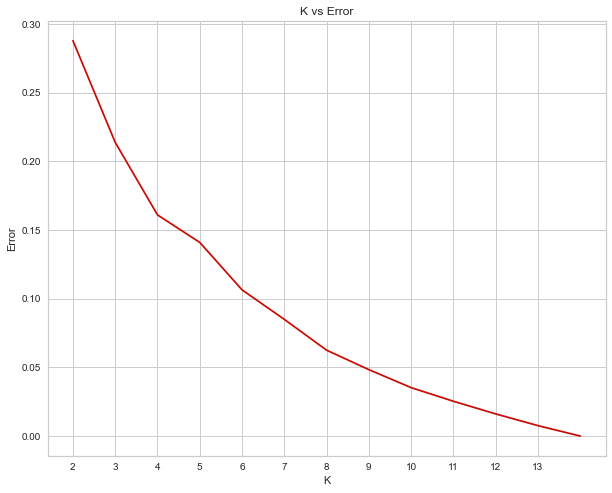

In [23]:
plt.figure(figsize=[10, 8])
plt.plot(range(2, 15), scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 14))
plt.xlabel("K")
plt.ylabel("Error")

We can evaluate this graph using the K Elbow visualizer function from the Yellowbrick.Cluster library 

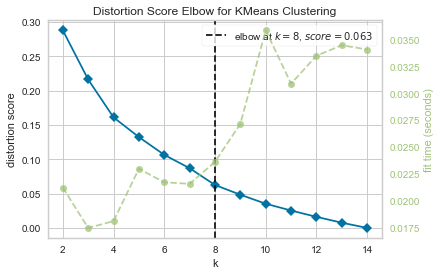

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

# Fit the data to the visualizer
visualizer.fit(townFeatures)        
visualizer.show()

This graph tells us that the optimum number of clusters for our data is 6.

In [25]:
# run k-means clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(townFeatures)

In [26]:
one_hot_londonTown['Cluster'] = kmeans.labels_

In [27]:
one_hot_londonTown[['Town', 'Cluster']]

,Town,Cluster
0,Bromley,4
1,Croydon,4
2,Feltham,2
3,Kingston,4
4,Morden,1
5,Norbury,5
6,Putney,1
7,Stoneleigh,0
8,Surbiton,1
9,Sutton,4


In [28]:

borough_df = borough_df.join(one_hot_londonTown[['Town', 'Cluster']].set_index('Town'), on='Town')

In [29]:
borough_df

,Town,Postcode,Latitude,Longitude,Cluster
0,Teddington,TW11 0AZ,51.42425,-0.33298,1
1,Kingston,KT1 1TP,51.41170,-0.30556,4
2,Surbiton,KT6 4PE,51.39268,-0.30441,1
3,Stoneleigh,KT19 0QZ,51.36366,-0.24879,0
4,Morden,SM4 5AZ,51.40212,-0.19473,1
5,Sutton,SM1 1DE,51.35963,-0.19151,4
6,Wallington,SM6 0DZ,51.36065,-0.15099,5
7,Thornton Heath,CR7 7JG,51.39848,-0.09956,3
8,Bromley,BR1 3NN,51.40825,0.01717,4
9,Croydon,CR0 2TA,51.37886,-0.10336,4


# Results
From our KNN analysis, we can see that Teddington is most similar to **Surbiton**, **Tooting** **Putney** and **Morden**, given they are all in cluster 1. Lets plot our clustering results on a map.

In [30]:
first_cluster_map = folium.Map(location=[51.4, -0.22], zoom_start=11)

clusterColours = ['red', 'green', 'blue', 'purple', 'black', 'orange']

for i, row in borough_df.iterrows():
  label = folium.Popup(f'{row.Town}')
  folium.CircleMarker(
      [row['Latitude'], row['Longitude']],
      radius=8,
      popup=label,
      color=clusterColours[row.Cluster],
      fill=True,
      fill_color=clusterColours[row.Cluster],
      fill_opacity=0.8,
      parse_html=False).add_to(first_cluster_map) 

first_cluster_map

# Discussion
Although this analysis is a good start, one issus is that the venue "catagory" is too granular. For this broarder analysis, I believe it is worth considering "clustering" the 153 different categories into more generic groups.

In [31]:
londonTowns_df_grouped = londonTowns_df.copy()

# beginning with some very simple lambda functions we can reduce our initial 151 catagories down to 101
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Pub' if 'Pub' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Café' if 'Café' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Café' if 'Cafe' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Café' if 'Coffee' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Bar' if 'Bar' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Public Transport' if 'Station' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Public Transport' if 'Bus' in x else x)
londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Gym' if 'Gym' in x else x)

 # Inspecting the remaining catagory list we can find other locations we can class as "restrauents" ...
other_restrauants = ['Pizza Place','Gastropub','Fish & Chips Shop',
  'Burger Joint','Burrito Place','Smoothie Shop','Sandwich Place',
  'Dessert Shop','Bistro','Tea Room','Breakfast Spot','Diner',
  'Steakhouse','Gelato Shop','Donut Shop','Chocolate Shop','Gaming Cafe',
  'Food Court','Candy Store','Ice Cream Shop','Pie Shop',
]
for R in other_restrauants:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Restaurant' if R in x else x)

# Other catacories we can class as "shops"
other_shops = ['Bookstore','Pharmacy','Optical Shop','Grocery Store',
  'Newsagent','Convenience Store','Theater','Liquor Store','Market',
  'Record Shop','Gift Shop','Clothing Store','Supermarket',
  'Department Store','Electronics Store','Betting Shop','Pet Store',
  'Flea Market','Garden Center','Hardware Store','Warehouse Store',
  'Video Game Store','Furniture / Home Store','Bridal Shop',
  'Arts & Crafts Store','Sporting Goods Shop','Carpet Store','Beer Store',
  'Cosmetics Shop','Bike Shop','Scenic Lookout','Wine Shop',
  'Shopping Plaza','Gun Shop'
]
for S in other_shops:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Shops' if S in x else x)

# and other locations we can count as sports facilities
other_sports = ['Gym','Pool','Golf Course','Soccer Stadium','Cricket Ground',
  'Mini Golf','Waterfront','Tennis Court','Yoga Studio','Sports Club',
  'Athletics & Sports','Soccer Field',
]
for Sp in other_sports:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'SportsFacilities' if Sp in x else x)

Now that we have the catagories refined further, we can run the same KNN analysis and see how this has affected the results. 

In [32]:
# Get one hot encoding of Category column
one_hot_encoding_refined = pd.get_dummies(londonTowns_df_grouped['Category'])

# create a new data frame
# given we are looking at the wider scale, we only need the Town value from our londown town frame
one_hot_encoding_refined = londonTowns_df_grouped.drop(
    ['Name', 'Postcode', 'Latitude', 'Longitude', 'Category'], 
    axis=1,
  ).join(
    one_hot_encoding_refined
  )

# we then group these by town and generate counts of each category for each town. 
one_hot_encoding_refined = one_hot_encoding_refined.groupby(by=['Town']).mean().reset_index()
one_hot_encoding_refined.head()

,Town,Auto Garage,Bakery,Bar,Boat or Ferry,Brewery,Café,Deli / Bodega,Farm,Forest,...,Playground,Plaza,Pub,Public Transport,Recreation Center,Restaurant,River,Rock Club,Shops,SportsFacilities
0,Bromley,0.000000,0.014925,0.044776,0.0,0.000000,0.104478,0.0,0.000000,0.0,...,0.0,0.00,0.119403,0.014925,0.0,0.283582,0.0,0.00,0.283582,0.074627
1,Croydon,0.000000,0.000000,0.011628,0.0,0.011628,0.139535,0.0,0.000000,0.0,...,0.0,0.00,0.104651,0.000000,0.0,0.372093,0.0,0.00,0.244186,0.034884
2,Feltham,0.000000,0.000000,0.050000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.00,0.050000,0.000000,0.0,0.300000,0.0,0.00,0.500000,0.050000
3,Kingston,0.000000,0.010000,0.020000,0.0,0.000000,0.140000,0.0,0.000000,0.0,...,0.0,0.01,0.160000,0.000000,0.0,0.410000,0.0,0.01,0.180000,0.020000
4,Morden,0.020408,0.020408,0.000000,0.0,0.000000,0.122449,0.0,0.020408,0.0,...,0.0,0.00,0.061224,0.102041,0.0,0.306122,0.0,0.00,0.224490,0.020408


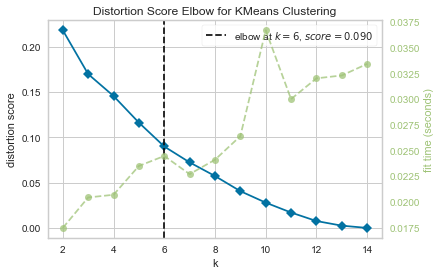

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))
townFeatures_refined = one_hot_encoding_refined.drop(['Town'], axis=1)


# Fit the data to the visualizer
visualizer.fit(townFeatures_refined)        
visualizer.show()

We see now that 7 clusters better fits our newliy refined catagories

In [34]:
# run k-means clustering with 7 cluster centres
kmeans_refined = KMeans(n_clusters=7, random_state=0).fit(townFeatures_refined)

one_hot_encoding_refined['Cluster'] = kmeans_refined.labels_

In [35]:
borough_df_2 = borough_df.drop('Cluster', axis=1).copy()
town_clusters = one_hot_encoding_refined[['Town', 'Cluster']].set_index('Town')
borough_df_2 = borough_df_2.join(town_clusters, on='Town')


# Refined results
And on closer inspection, we learn that Tooting is best clustered with **Putney** and **Surbiton**

In [36]:
refined_cluster_map = folium.Map(location=[51.4, -0.22], zoom_start=11)

clusterColours = ['red', 'green', 'blue', 'purple', 'black', 'orange', 'yellow']

for i, row in borough_df_2.iterrows():
  label = folium.Popup(f'{row.Town}')
  folium.CircleMarker(
      [row['Latitude'], row['Longitude']],
      radius=8,
      popup=label,
      color=clusterColours[row.Cluster],
      fill=True,
      fill_color=clusterColours[row.Cluster],
      fill_opacity=0.8,
      parse_html=False).add_to(refined_cluster_map) 

refined_cluster_map

# Conclusions
I hope that this project has provided an insight into how businesses can use simple data science techniques to impact real-world solutions. From this simple analysis, we would suggest to clients areas that are similar to their current location. 
Were this an actual client, I would suggest that we could take this analysis even further. Given the clients initial street address, we could build up a more detailed picture of their area and perform a far more detailed KNN clustering analysis of different London boroughs. Each model could also be tailored to meet client-specific needs; are they interested in close by transport links? Do they want a good selection of pizza restaurants? Ect.
This project is the first step in an analysis process that could go almost infinitely deep. Hopefully, I have been able to demonstrate the power of data science in real-world applications. 
